## Baseline

### Imports

In [1]:
!pip install datasets
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-15p4468t
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-15p4468t
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=fb3191291474fb2e3c0dbf371e449b2feab58958c0d0f0bee9023d4cd7d706d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-kjvmehf8/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import torch
from torch import nn
from datasets import load_dataset
from diffusers import StableDiffusionPipeline, DDIMScheduler
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image
import clip
from tqdm import tqdm

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### Data preparation

In [3]:
num_samples = 3 # low for demo purposes, set 100 or more for real exps
dataset = load_dataset("vinesmsuic/GenAI-Bench_image_edition_processed")
dataset = dataset['train']

def get_preferred_image(row):
    if row['vote_type'] == 'rightvote':
        return row['right_output_image']
    else:
        return row['left_output_image']

def is_valid_size(image, size=(512, 512)):
    """Check if image has the required dimensions"""
    return image.size == size

valid_indices = []
for idx, item in enumerate(dataset):
    source_img = item['source_image']
    preferred_img = get_preferred_image(item)

    if is_valid_size(source_img) and is_valid_size(preferred_img):
        valid_indices.append(idx)

dataset = dataset.select(valid_indices)
dataset = dataset.select(range(num_samples))

dataset = {
    'source_image': dataset['source_image'],
    'target_prompt': dataset['target_prompt'],
    'source_prompt': dataset['source_prompt'],
    'instruct_prompt': dataset['instruct_prompt'],
    'target_image': [get_preferred_image(row) for row in dataset],
    'vote_type': dataset['vote_type'],
    'preference': dataset['preferences']
}

README.md:   0%|          | 0.00/972 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/97.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/919 [00:00<?, ? examples/s]

### Model Setup

In [4]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

model_name = "CompVis/stable-diffusion-v1-4"
stable_diffusion = StableDiffusionPipeline.from_pretrained(
    model_name,
    scheduler=scheduler
).to("cuda")

clip_model, clip_preprocess = clip.load("ViT-B/32", device="cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:221: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for th

In [5]:
tokenizer = stable_diffusion.tokenizer

### Baseline Generation

In [10]:
generated_images = []

for prompt, src_image in tqdm(zip(dataset['target_prompt'], dataset['source_image']), total=len(dataset['target_prompt'])):
    images = stable_diffusion(
        prompt,
        heihht=src_image.size[0],
        width=src_image.size[1],
        num_inference_steps=50,
        guidance_scale=7.5,
        progress_bar=False).images
    generated_images.extend(images)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:27<00:55, 27.61s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:56<00:28, 28.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:23<00:00, 27.95s/it]


In [11]:
from IPython.display import FileLink

generated_images_np = np.array([np.array(img) for img in generated_images])

filename = "generated_images.npy"
np.save(filename, generated_images_np)
FileLink(filename)

/kaggle/working/generated_images.npy

### Generation results (classifier-free-guidance)

A skateboarder with a hat is doing a trick on a hand rail.


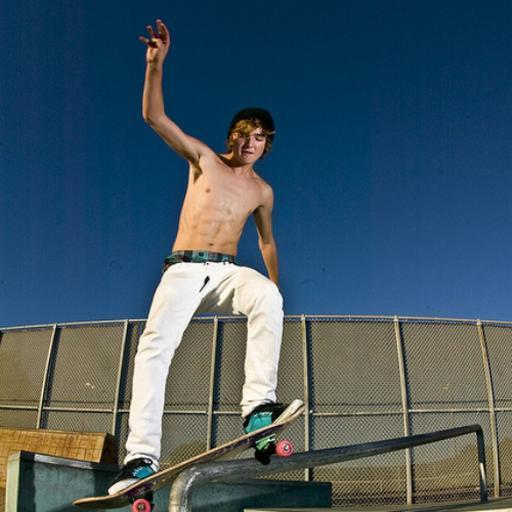

In [12]:
print( dataset['target_prompt'][2])
dataset['source_image'][2]

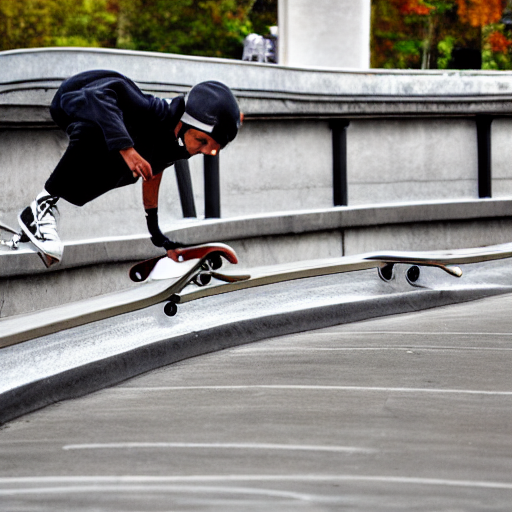

In [13]:
generated_images[2]

### Baseline evaluation
__SSIM, CLIP similarity (img2img, img2text)__

In [14]:
def compute_ssim(img1, img2):
    """Compute SSIM between two images"""
    # Convert PIL images to numpy arrays
    img1_np = np.array(img1.convert('L'))
    img2_np = np.array(img2.convert('L'))

    return ssim(img1_np, img2_np)

In [15]:
def compute_clip_similarity_img2img(clip_model, clip_preprocess, img1, img2):
    """Compute CLIP similarity between images or image and text"""
    # Image to image clip similarity
    img1_processed = clip_preprocess(img1).unsqueeze(0).to("cuda")
    img2_processed = clip_preprocess(img2).unsqueeze(0).to("cuda")

    with torch.no_grad():
        img1_features = clip_model.encode_image(img1_processed)
        img2_features = clip_model.encode_image(img2_processed)
        similarity = torch.cosine_similarity(img1_features, img2_features).item()

    return similarity

def compute_clip_similarity_img2text(clip_model, clip_preprocess, img, text):
    # Image to text clip similarity
    img_processed = clip_preprocess(img).unsqueeze(0).to("cuda")
    text_tokens = clip.tokenize([text]).to("cuda")
    with torch.no_grad():
        img_features = clip_model.encode_image(img_processed)
        text_features = clip_model.encode_text(text_tokens)
        similarity = torch.cosine_similarity(img_features, text_features).item()

    return similarity

In [16]:
metrics = {
    'ssim_scores': [],
    'clip_img2img_target_scores': [],
    'clip_img2img_source_scores': [],
    'clip_img2text_target_scores': [],
    'clip_img2text_source_scores': [],
}

for gen_img, source_img, source_prompt, target_img, target_prompt in zip(generated_images, dataset['source_image'], dataset['source_prompt'], dataset['target_image'], dataset['target_prompt']):
    # Compute SSIM
    ssim_score = compute_ssim(gen_img, target_img)
    metrics['ssim_scores'].append(ssim_score)

    # Compute CLIP similarities
    metrics['clip_img2img_target_scores'].append(compute_clip_similarity_img2img(clip_model, clip_preprocess, gen_img, target_img))
    metrics['clip_img2img_source_scores'].append(compute_clip_similarity_img2img(clip_model, clip_preprocess, gen_img, source_img))
    metrics['clip_img2text_target_scores'].append(compute_clip_similarity_img2text(clip_model, clip_preprocess, gen_img, target_prompt))
    metrics['clip_img2text_source_scores'].append(compute_clip_similarity_img2text(clip_model, clip_preprocess, gen_img, source_prompt))

In [17]:
for metric_name, scores in metrics.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{metric_name}:\t{mean_score:.4f} (±{std_score:.4f})")

ssim_scores:	0.1767 (±0.0544)
clip_img2img_target_scores:	0.6945 (±0.1034)
clip_img2img_source_scores:	0.6722 (±0.0707)
clip_img2text_target_scores:	0.3170 (±0.0098)
clip_img2text_source_scores:	0.2931 (±0.0160)


## DDIM Inversion

### Implementation

In [18]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image
import torch.nn.functional as F
from tqdm.auto import tqdm

class DDIMInversion:
    def __init__(self):
        pass

    def preprocess_image(self, image):
        """Preprocess image for VAE input"""
        if isinstance(image, Image.Image):
            image = image.resize((512, 512))
            image = torch.from_numpy(np.array(image)).float() / 127.5 - 1
            image = image.permute(2, 0, 1).unsqueeze(0).to("cuda")
        return image

    def encode_images(self, pipeline, images):
        """Encode images to latent space"""
        with torch.no_grad():
            latents = pipeline.vae.encode(images).latent_dist.sample()
            latents = latents * 0.18215
        return latents

    def _next_step(self, model_output, timestep, sample, scheduler):
        timestep, next_timestep = min(timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = scheduler.alphas_cumprod[timestep] if timestep >= 0 else scheduler.final_alpha_cumprod
        alpha_prod_t_next = scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample

    def ddim_inversion(self, pipeline, image, prompt, num_inference_steps=200, num_real_steps=80):
        """Perform DDIM inversion to get latents"""
        pipeline.scheduler.set_timesteps(num_inference_steps)

        # Preprocess and encode image
        image = self.preprocess_image(image)
        latents = [self.encode_images(pipeline, image)]

        # Get text embeddings
        text_embeddings = pipeline._encode_prompt(
            prompt,
            device="cuda",
            num_images_per_prompt=1,
            do_classifier_free_guidance=True
        )

        # Initialize timesteps
        timesteps = pipeline.scheduler.timesteps.flip(0)

        # DDIM inversion
        print("Performing DDIM inversion...")
        for i in tqdm(np.arange(num_real_steps)):
            # Expand latents for classifier free guidance
            t = timesteps[i]
            latent_model_input = torch.cat([latents[-1]] * 2)

            # Predict noise
            with torch.no_grad():
                noise_pred = pipeline.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings
                ).sample

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + 1 * (noise_pred_text - noise_pred_uncond)

            # DDIM reverse step
            latents += [self._next_step(noise_pred, t, latents[-1], pipeline.scheduler)]

        return latents

    def regenerate_with_target(self, pipeline, latents, target_prompt, num_inference_steps=200, num_real_steps=50):
        """Generate new image from inverted latents using target prompt"""
        steps=num_real_steps
        latents = latents[steps]
        pipeline.scheduler.set_timesteps(num_inference_steps)

        # Get text embeddings for target prompt
        text_embeddings = pipeline._encode_prompt(
            target_prompt,
            device="cuda",
            num_images_per_prompt=1,
            do_classifier_free_guidance=True
        )

        # Generation loop
        print("Generating with target prompt...")
        for i in tqdm(np.arange(0, num_inference_steps)):
            t = pipeline.scheduler.timesteps[i]
            # Expand latents for classifier free guidance
            latent_model_input = torch.cat([latents] * 2)

            # Predict noise
            with torch.no_grad():
                noise_pred = pipeline.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings
                ).sample

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + 1 * (noise_pred_text - noise_pred_uncond)

            # DDIM step
            latents = pipeline.scheduler.step(
                noise_pred,
                t,
                latents
            ).prev_sample

        # Decode latents to image
        with torch.no_grad():
            latents = 1 / 0.18215 * latents
            image = pipeline.vae.decode(latents).sample

        # Postprocess image
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        image = Image.fromarray(image[0])

        return image

# Example usage
def edit_image(pipeline, source_image, source_prompt, target_prompt, num_inference_steps=1000, num_real_steps=500):
    """Edit image using DDIM inversion and target prompt"""
    # Initialize model
    ddim_inv = DDIMInversion()

    # Perform inversion
    inverted_latents = ddim_inv.ddim_inversion(pipeline, source_image, source_prompt, num_inference_steps=num_inference_steps, num_real_steps=num_real_steps)

    # Generate with target prompt
    edited_image = ddim_inv.regenerate_with_target(pipeline, inverted_latents, target_prompt, num_inference_steps=num_inference_steps, num_real_steps=num_real_steps)

    return edited_image

In [19]:
generated_images_ddim = []
generated_sources_ddim = []

for source_prompt, target_prompt, src_image in tqdm(zip(dataset['source_prompt'], dataset['target_prompt'], dataset['source_image']), total=len(dataset['target_prompt'])):
    gen_image = edit_image(stable_diffusion, src_image, source_prompt, target_prompt, num_inference_steps=50, num_real_steps=50)
    gen_source_image = edit_image(stable_diffusion, src_image, source_prompt, source_prompt, num_inference_steps=50, num_real_steps=50)
    generated_images_ddim.append(gen_image)
    generated_sources_ddim.append(gen_source_image)

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:303: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


Performing DDIM inversion...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

A skateboarder with a hat is doing a trick on a hand rail.


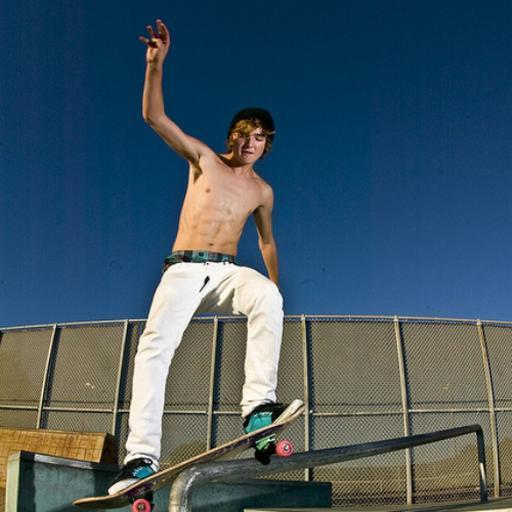

In [21]:
print(dataset['target_prompt'][2])
dataset['source_image'][2]

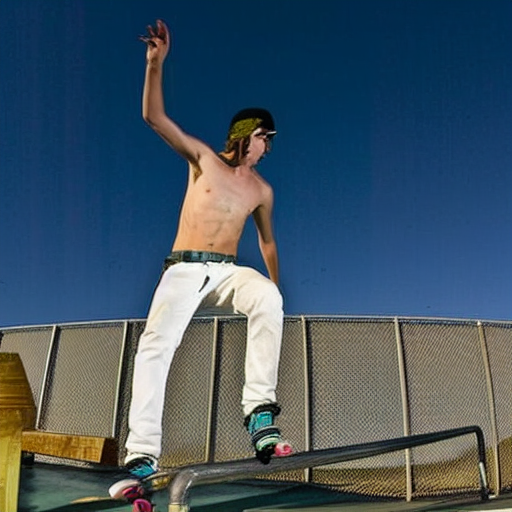

In [22]:
generated_sources_ddim[2]

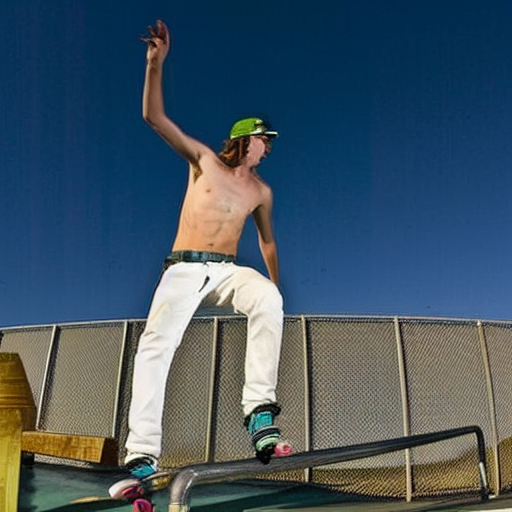

In [23]:
generated_images_ddim[2]

In [24]:
metrics = {
    'ssim_scores': [],
    'clip_img2img_target_scores': [],
    'clip_img2img_source_scores': [],
    'clip_img2text_target_scores': [],
    'clip_img2text_source_scores': [],
}

for gen_img, source_img, source_prompt, target_img, target_prompt in zip(generated_images_ddim, dataset['source_image'], dataset['source_prompt'], dataset['target_image'], dataset['target_prompt']):
    # Compute SSIM
    ssim_score = compute_ssim(gen_img, target_img)
    metrics['ssim_scores'].append(ssim_score)

    # Compute CLIP similarities
    metrics['clip_img2img_target_scores'].append(compute_clip_similarity_img2img(clip_model, clip_preprocess, gen_img, target_img))
    metrics['clip_img2img_source_scores'].append(compute_clip_similarity_img2img(clip_model, clip_preprocess, gen_img, source_img))
    metrics['clip_img2text_target_scores'].append(compute_clip_similarity_img2text(clip_model, clip_preprocess, gen_img, target_prompt))
    metrics['clip_img2text_source_scores'].append(compute_clip_similarity_img2text(clip_model, clip_preprocess, gen_img, source_prompt))

In [25]:
for metric_name, scores in metrics.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{metric_name}:\t{mean_score:.4f} (±{std_score:.4f})")

ssim_scores:	0.6873 (±0.1238)
clip_img2img_target_scores:	0.8665 (±0.0618)
clip_img2img_source_scores:	0.8787 (±0.0510)
clip_img2text_target_scores:	0.3071 (±0.0096)
clip_img2text_source_scores:	0.2659 (±0.0584)


In [26]:
from IPython.display import FileLink

generated_images_np = np.array([np.array(img) for img in generated_images_ddim])

filename = "generated_images_ddim.npy"
np.save(filename, generated_images_np)
FileLink(filename)

/kaggle/working/generated_images_ddim.npy

## Null-text inversion

In [27]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.optim.adam import Adam
import copy

class NullTextInversion:
    def __init__(self):
        pass

    def _prev_step(self, model_output, timestep, sample, scheduler):
        # https://github.com/google/prompt-to-prompt/blob/main/null_text_w_ptp.ipynb
        prev_timestep = timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps
        alpha_prod_t = scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample

    def _next_step(self, model_output, timestep, sample, scheduler):
        timestep, next_timestep = min(timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = scheduler.alphas_cumprod[timestep] if timestep >= 0 else scheduler.final_alpha_cumprod
        alpha_prod_t_next = scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample

    def preprocess_image(self, image):
        """Preprocess image for VAE input"""
        if isinstance(image, Image.Image):
            image = image.resize((512, 512))
            image = torch.from_numpy(np.array(image)).float() / 127.5 - 1
            image = image.permute(2, 0, 1).unsqueeze(0).to("cuda")
        return image

    def encode_images(self, pipeline, images):
        """Encode images to latent space"""
        with torch.no_grad():
            latents = pipeline.vae.encode(images).latent_dist.sample()
            latents = latents * 0.18215
        return latents

    def ddim_inversion(self, pipeline, image, prompt, num_inference_steps=200):
        """Perform DDIM inversion to get latents"""
        pipeline.scheduler.set_timesteps(num_inference_steps)

        # Preprocess and encode image
        image = self.preprocess_image(image)
        latents = [self.encode_images(pipeline, image)]

        # Get text embeddings
        text_embeddings = pipeline._encode_prompt(
            prompt,
            device="cuda",
            num_images_per_prompt=1,
            do_classifier_free_guidance=True
        )

        # Initialize timesteps
        timesteps = pipeline.scheduler.timesteps.flip(0)

        # DDIM inversion
        print("Performing DDIM inversion...")
        for i in tqdm(np.arange(num_inference_steps)):
            # Expand latents for classifier free guidance
            t = timesteps[i]
            latent_model_input = torch.cat([latents[-1]] * 2)

            # Predict noise
            with torch.no_grad():
                noise_pred = pipeline.unet(
                    latent_model_input,
                    timesteps[i],
                    encoder_hidden_states=text_embeddings
                ).sample

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + 1 * (noise_pred_text - noise_pred_uncond)

            # DDIM reverse step
            latents += [self._next_step(noise_pred, t, latents[-1], pipeline.scheduler)]

        return latents

    def null_text_inversion(self, pipeline, image, prompt, latents, num_inference_steps=200):
        """Perform DDIM inversion to get latents"""
        pipeline.scheduler.set_timesteps(num_inference_steps)

        # print(num_inference_steps, len(pipeline.scheduler.timesteps))

        # Preprocess and encode image
        image = self.preprocess_image(image)

        # Get text embeddings
        null_input = pipeline.tokenizer(
            [""], padding="max_length", max_length=pipeline.tokenizer.model_max_length,
            return_tensors="pt"
        )
        null_embeddings = pipeline.text_encoder(null_input.input_ids.to('cuda'))[0]
        text_input = pipeline.tokenizer(
            [prompt],
            padding="max_length",
            max_length=pipeline.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = pipeline.text_encoder(text_input.input_ids.to('cuda'))[0]

        timesteps = pipeline.scheduler.timesteps

        print("Performing null-text inversion...")

        uncond_embeddings_list = []
        latent_cur = latents[-1].detach()
        latent_cur.requires_grad = False

        print("N timestamps ", len(timesteps))

        for i in tqdm(np.arange(0, num_inference_steps)):
            # Expand latents for classifier free guidance
            t = timesteps[i]

            null_embeddings_new = (uncond_embeddings_list[-1] if i > 0 else null_embeddings).clone().detach()
            null_embeddings_new.requires_grad = True
            optimizer = Adam([null_embeddings_new], lr=1e-2 * (1. - i / 100.))

            latent_model_input = torch.cat([latent_cur] * 2)
            with torch.no_grad():
                noise_pred_text = pipeline.unet(latent_cur, t, encoder_hidden_states=text_embeddings)['sample']

            num_train_iters = 10
            
            iters = 0
            for _ in range(num_train_iters):
                iters += 1
                noise_pred_uncond = pipeline.unet(latent_cur, t, encoder_hidden_states=null_embeddings_new)['sample']

                # Perform guidance
                noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)
                latents_prev_rec = self._prev_step(noise_pred, t, latent_cur, pipeline.scheduler)
                
                # Train null text embedding to closer match latents from the forward process 
                optimizer.zero_grad()
                loss = torch.nn.functional.mse_loss(latents_prev_rec, latents[-i-2])
                loss.backward()
                optimizer.step()
                if loss.item() < 1e-5 + i * 2e-5:
                    break


            uncond_embeddings_list.append(null_embeddings_new[:1].detach())
            
            # Guidance step with new null-text embedding
            with torch.no_grad():
                noise_pred_text = pipeline.unet(latent_cur, t, encoder_hidden_states=text_embeddings)['sample']
                noise_pred_uncond = pipeline.unet(latent_cur, t, encoder_hidden_states=null_embeddings_new)['sample']
            noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

            # DDIM step
            latent_cur = self._prev_step(noise_pred, t, latent_cur, pipeline.scheduler).detach()

            latent_cur.requires_grad = False

        return latents, uncond_embeddings_list

    def regenerate_with_target(self, pipeline, latents, null_embeddings, target_prompt, num_inference_steps=200):
        """
        Generate new image from inverted latents using target prompt
        Is closely similar to the regenerate function for DDIM inversion, but uses different null embeddings on each step
        """
        latents = latents[-1]
        pipeline.scheduler.set_timesteps(num_inference_steps)

        # Get text embeddings for target prompt
        text_input = pipeline.tokenizer(
            [target_prompt],
            padding="max_length",
            max_length=pipeline.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = pipeline.text_encoder(text_input.input_ids.to('cuda'))[0]

        print("N timestamps 2 ", len(pipeline.scheduler.timesteps))

        # Generation loop
        print("Generating with target prompt...")
        for i in tqdm(np.arange(0, num_inference_steps)):
            t = pipeline.scheduler.timesteps[i]
            # Predict noise
            with torch.no_grad():
                noise_pred_text = pipeline.unet(latents, t, encoder_hidden_states=text_embeddings)['sample']
                noise_pred_uncond = pipeline.unet(latents, t, encoder_hidden_states=null_embeddings[i])['sample']

            # Perform guidance
            noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

            # DDIM step
            latents = pipeline.scheduler.step(
                noise_pred,
                t,
                latents
            ).prev_sample

        # Decode latents to image
        with torch.no_grad():
            latents = 1 / 0.18215 * latents
            image = pipeline.vae.decode(latents).sample

        # Postprocess image
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        image = Image.fromarray(image[0])

        return image

# Example usage
def edit_image(pipeline, source_image, source_prompt, target_prompt, num_inference_steps=100):
    """Edit image using Null-text inversion and target prompt"""
    # Initialize model
    null_text_inv = NullTextInversion()

    # DDIM inversion to get latents
    inverted_latents = null_text_inv.ddim_inversion(pipeline, source_image, source_prompt, num_inference_steps=num_inference_steps)

    # Perform inversion
    inverted_latents, null_embeddings = null_text_inv.null_text_inversion(pipeline, source_image, source_prompt, inverted_latents, num_inference_steps=num_inference_steps)

    # Generate with target prompt
    edited_image = null_text_inv.regenerate_with_target(pipeline, inverted_latents, null_embeddings, target_prompt, num_inference_steps=num_inference_steps)

    # Regenerate with source prompt
    regenerated_src_image = null_text_inv.regenerate_with_target(pipeline, inverted_latents, null_embeddings, source_prompt, num_inference_steps=num_inference_steps)

    return edited_image, regenerated_src_image

In [28]:
generated_images_null_text = []
generated_images_src_null_text = []

for source_prompt, target_prompt, src_image in tqdm(list(zip(dataset['source_prompt'], dataset['target_prompt'], dataset['source_image'])), total=len(dataset['target_prompt'])):
    gen_image, gen_src_image = edit_image(stable_diffusion, src_image, source_prompt, target_prompt, num_inference_steps=50)
    generated_images_null_text.append(gen_image)
    generated_images_src_null_text.append(gen_src_image)

  0%|          | 0/3 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/50 [00:00<?, ?it/s]

Performing null-text inversion...
N timestamps  50


  0%|          | 0/50 [00:00<?, ?it/s]

N timestamps 2  50
Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

N timestamps 2  50
Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/50 [00:00<?, ?it/s]

Performing null-text inversion...
N timestamps  50


  0%|          | 0/50 [00:00<?, ?it/s]

N timestamps 2  50
Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

N timestamps 2  50
Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

Performing DDIM inversion...


  0%|          | 0/50 [00:00<?, ?it/s]

Performing null-text inversion...
N timestamps  50


  0%|          | 0/50 [00:00<?, ?it/s]

N timestamps 2  50
Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

N timestamps 2  50
Generating with target prompt...


  0%|          | 0/50 [00:00<?, ?it/s]

A skateboarder with a hat is doing a trick on a hand rail.


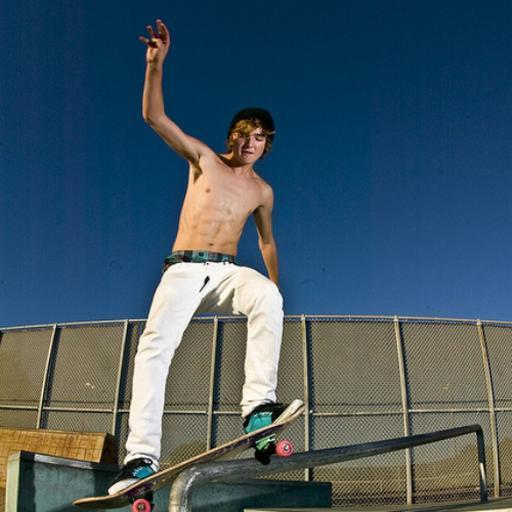

In [29]:
print(dataset['target_prompt'][2])
dataset['source_image'][2]

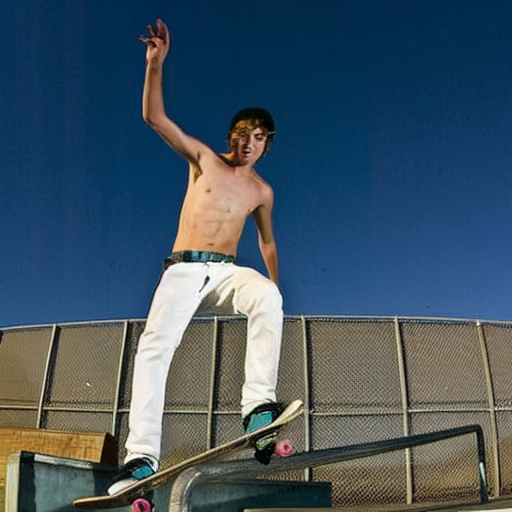

In [30]:
generated_images_src_null_text[2]

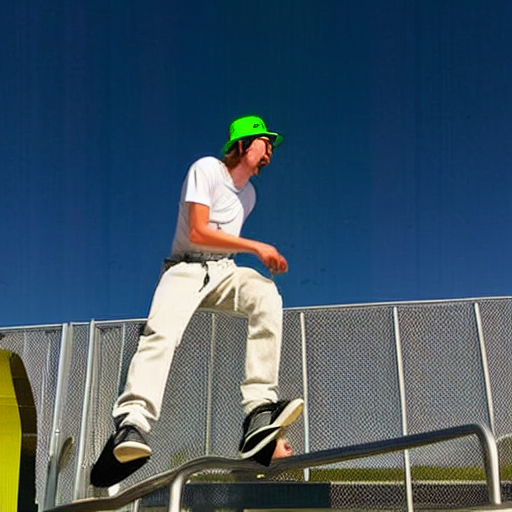

In [31]:
generated_images_null_text[2]

In [32]:
from IPython.display import FileLink

generated_images_np = np.array([np.array(img) for img in generated_images_null_text])

filename = "generated_images_null_text.npy"
np.save(filename, generated_images_np)
FileLink(filename)

/kaggle/working/generated_images_null_text.npy